# Code for the Hyperspectral Image Denoising via Matrix Factorization and Deep Prior Regularization Paper

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, Dense, BatchNormalization, Concatenate, Add
from keras.callbacks import ModelCheckpoint

%matplotlib inline

# set seed for reproducibility
tf.random.set_seed(42)

Initializations of:
- M and N = size of image
- L = spectral bands of image
- X = image
- sigma = standard deviation
- N = white gaussain noise
- S = sparse noise

In [ ]:
# please note that the values of M, N, L might be changed in the future
M, N, L = 512, 512, 640

# M*N hyperspectral image with L spectral bands
X = tf.random.uniform(shape=([M,N,L]), minval=-1, maxval=1, 
                      dtype=tf.float32, seed=42, name='X')

# white Gaussian noise N(0, sigma**2)
# sigma = 
# N = 

# sparse noise
# S = np.random.default_rng().laplace(, , 1000)

# Model Architecture

**I'm using functional API, as subclassing API is giving errors...**

In [26]:
# Input as specified in the paper
M, N, L = 180, 180, 1   # these are the values mentioned in the paper
input_shape = (400, M, N, L)
input_layer = Input(shape=input_shape)

# Skip connection
inputs_skip_connection = list(input_shape)
inputs_skip_connection[-1] = 64
# inputs_skip_connection = inputs_skip_connection[2:]
inputs_skip_connection = Input(shape=inputs_skip_connection)

# Model starts
model_input = input_layer
# Block 1
x = Conv3D(filters=64, kernel_size=(3,3,1), activation='relu', padding='same', strides=1, 
           dilation_rate=1, name='block1')(model_input)
x = BatchNormalization()(x)
# Block 2
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1, 
           dilation_rate=2, name='block2')(x)
x = BatchNormalization()(x)
# Block 3
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=4, name='block3')(x)
x = BatchNormalization()(x)
# Block 4
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=3, name='block4')(x)
x = BatchNormalization()(x)
# Block 5
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=4, name='block5')(x)
x = BatchNormalization()(x)
# Block 6
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=2, name='block6')(x)
x = BatchNormalization()(x)
# Block 7
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=1, name='block7')(x)
x = Concatenate(axis=1)([x, inputs_skip_connection])
# x = Add()([x, inputs_skip_connection])
output = BatchNormalization()(x)

In [27]:
mymodel = Model(model_input, output)
mymodel.summary()

ValueError: ignored

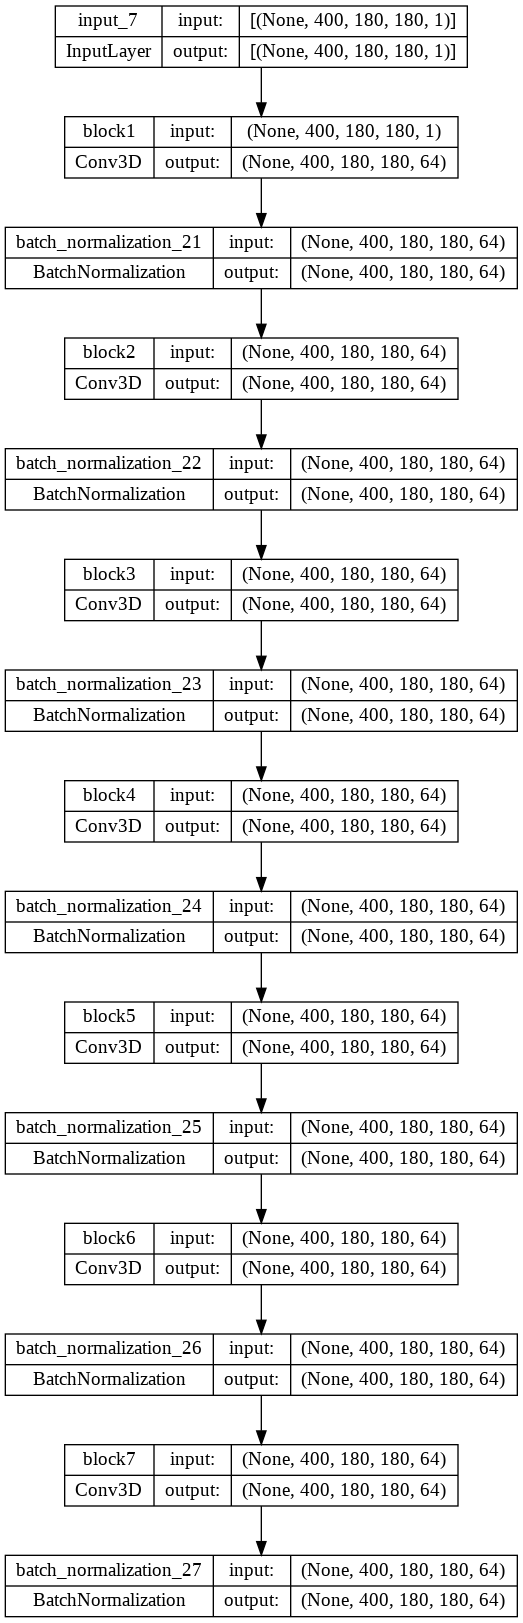

In [17]:
# Show graph of the model
keras.utils.plot_model(mymodel, "my_model_graph.png", show_shapes=True)

In [ ]:
class HSI_Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.block1 = layers.Conv3D(filters=64, kernel_size=(3,3,1), padding='same', strides=1, 
                                    dilation_rate=1, name='block1')
        self.block2 = layers.Conv3D(filters=64, kernel_size=(3,3,64), padding='same', strides=1,
                                   dilation_rate=2, name='block2')
        self.block3 = layers.Conv3D(filters=64, kernel_size=(3,3,64), padding='same', strides=1,
                                   dilation_rate=4, name='block3')
        self.block4 = layers.Conv3D(filters=64, kernel_size=(3,3,64), padding='same', strides=1,
                                   dilation_rate=3, name='block4')
        self.block5 = layers.Conv3D(filters=64, kernel_size=(3,3,64), padding='same', strides=1,
                                   dilation_rate=4, name='block5')
        self.block6 = layers.Conv3D(filters=64, kernel_size=(3,3,64), padding='same', strides=1,
                                   dilation_rate=2, name='block6')
        self.block7 = layers.Conv3D(filters=64, kernel_size=(3,3,64), padding='same', strides=1,
                                   dilation_rate=1, name='block7')
        self.relu = layers.ReLU()
        self.bnorm = layers.BatchNormalization()
        
    def call(self, inputs):
        # block 1 (I wrote this in an expanded manner and the rest of the blocks in just 1 line)
        x = inputs
        # I modified the input as it was getting <=0 due to downsampling from block3
        # Also, I had to change the padding from valid to same as the input was getting downsampled
        # The below code under the comment debugging is made to match the dimensions for concatentation
        # DEBUGGING
        inputs_skip_connection = list(inputs.shape)
        inputs_skip_connection[-1] = 64
        inputs_skip_connection = inputs_skip_connection[1:]
        inputs_skip_connection = layers.Input(shape=inputs_skip_connection)
        # DEBUGGING
        x = self.block1(inputs)
        x = self.relu(x)
        x = self.bnorm(x)
        # block 2
        x = self.bnorm(self.relu(self.block2(x)))
        # block 3
        x = self.bnorm(self.relu(self.block3(x)))
        # block 4
        x = self.bnorm(self.relu(self.block4(x)))
        # block 5
        x = self.bnorm(self.relu(self.block5(x)))
        # block 6
        x = self.bnorm(self.relu(self.block6(x)))
        # block 7
        x = self.block7(x)
        x = layers.Concatenate(axis=1)([x,inputs_skip_connection])  # implements skip connection
        output = self.relu(x)
        
        return output

There are 3 errors I am facing:
- Since the input dimension is getting <=0 due to the downsampling action from block3, so I had to change the padding from valid to same
- To implement the skip connection, I have to use the concatenate layer. For that I need to match the input dimension with the dimension of the output of block7. So, I changed the dimension of the input for skip connection from 1 to 64.
- Finally, having resolved all these, I am now facing the error:
```python
"Could not build a TypeSpec for KerasTensor(type_spec=TensorSpec(shape=(None, 800, 180, 180, 64), dtype=tf.float32, name=None), name='re_lu_8/Relu:0', description="created by layer 're_lu_8'") of unsupported type <class 'keras.engine.keras_tensor.KerasTensor'>."
```

In [ ]:
# inputs = tf.keras.Input(shape=(None, M, N, L))
M, N, L = 180, 180, 1   # these are the values mentioned in the paper
input_shape = (400, M, N, L)
model_input = Input(shape=input_shape)

model1 = HSI_Model()
model1(model_input)

model1.summary()

TypeError: ignored

# Model Hyperparameters

In [ ]:
lr = 1e-3    # also try 3e-4 (aka karpathy's constant)
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
weight_decay = 1e-4
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, weight_decay=weight_decay, 
                                                  beta_1=b1, beta_2=b2, epsilon=epsilon)
epochs = 60
minibatch_size = 256

# we'll have to design a custom loss function as specified in the paper

model1.compile()

In [ ]:
model1(model_input)